# 기본 함수 및 라이브러리 로드

In [1]:
# 경고 제어
import warnings
warnings.filterwarnings('ignore')

# 기본 전처리
import numpy as np
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.4f}'.format

# 시각화
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12, 9)
from scipy.stats import norm

## 필요 함수 로드

In [2]:
def get_object_type(df):
    """ 
    상권코드의 type을 str로 바꿈
    상권_이름을 삭제
    """
    
    df['상권_코드'] = df['상권_코드'].apply(lambda x: str(x))
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
### Scaler들의 함수를 정의함 ###
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1))

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [4]:
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

def get_summary(X, y):
    """
    p-value를 체크하는 한다
    """
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

## 검정 함수
### vif 관련 함수

In [5]:
def get_vif(X, least=100, show=False):
    """
    vif를 구하고 이를 데이터 프레임화
    초기 vif 제한수를 100으로 지정
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    
    if show:
        print(vif, '\n')
        
    vif = vif[vif['features'] != 'const']
    return vif[vif['VIF Factor'] > least]

##### AIC 시각화

In [6]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC = result['AIC'].to_list()
    features = [f'step {i+1}\n' + '\n'.join(s) for i, s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps, AIC, marker='o')
    
    plt.ylabel('AIC', fontsize=font_size)
    plt.grid(True)
    plt.show()

### 최적화 함수

In [7]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

### PCA 함수

In [8]:
from sklearn.decomposition import PCA

def decompo_pca(df, col, new_col):
    
    pca = PCA(n_components=1)
    df[new_col] = pca.fit_transform(pca_df[col])
    df.drop(col, axis=1, inplace=True)
    
    return df

# Data Load

In [9]:
df_i2= pd.read_csv('../data/indicator/preprocess_geo.csv', index_col='상권_코드')
df_i2.head(3)

,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,아파트_평균_면적,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수
상권_코드,,,,,,,,,,,,,,,,,,,,,,,
1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,255243240.7500,68.0000,230.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,48.0000,114.0000,0.0000,34.0000
1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,229979099.5866,49.7500,29.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,9.0000,0.0000,4.0000
1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,177736607.7500,50.0000,152.0000,1.0000,3.0000,0.0000,0.0000,0.0000,4.0000,8.0000,0.0000,0.0000,1.0000,0.0000,3.0000,27.0000,0.0000,16.0000


In [10]:
df_X = df_i2.copy()
df_y = pd.read_csv('../data/base_data/target.csv', index_col='상권_코드')
df_y.head()

,면적당_매출
상권_코드,
1000001,41.1679
1000002,147.5076
1000003,58.5448
1000004,202.0712
1000005,5.4252


# 1차 분석

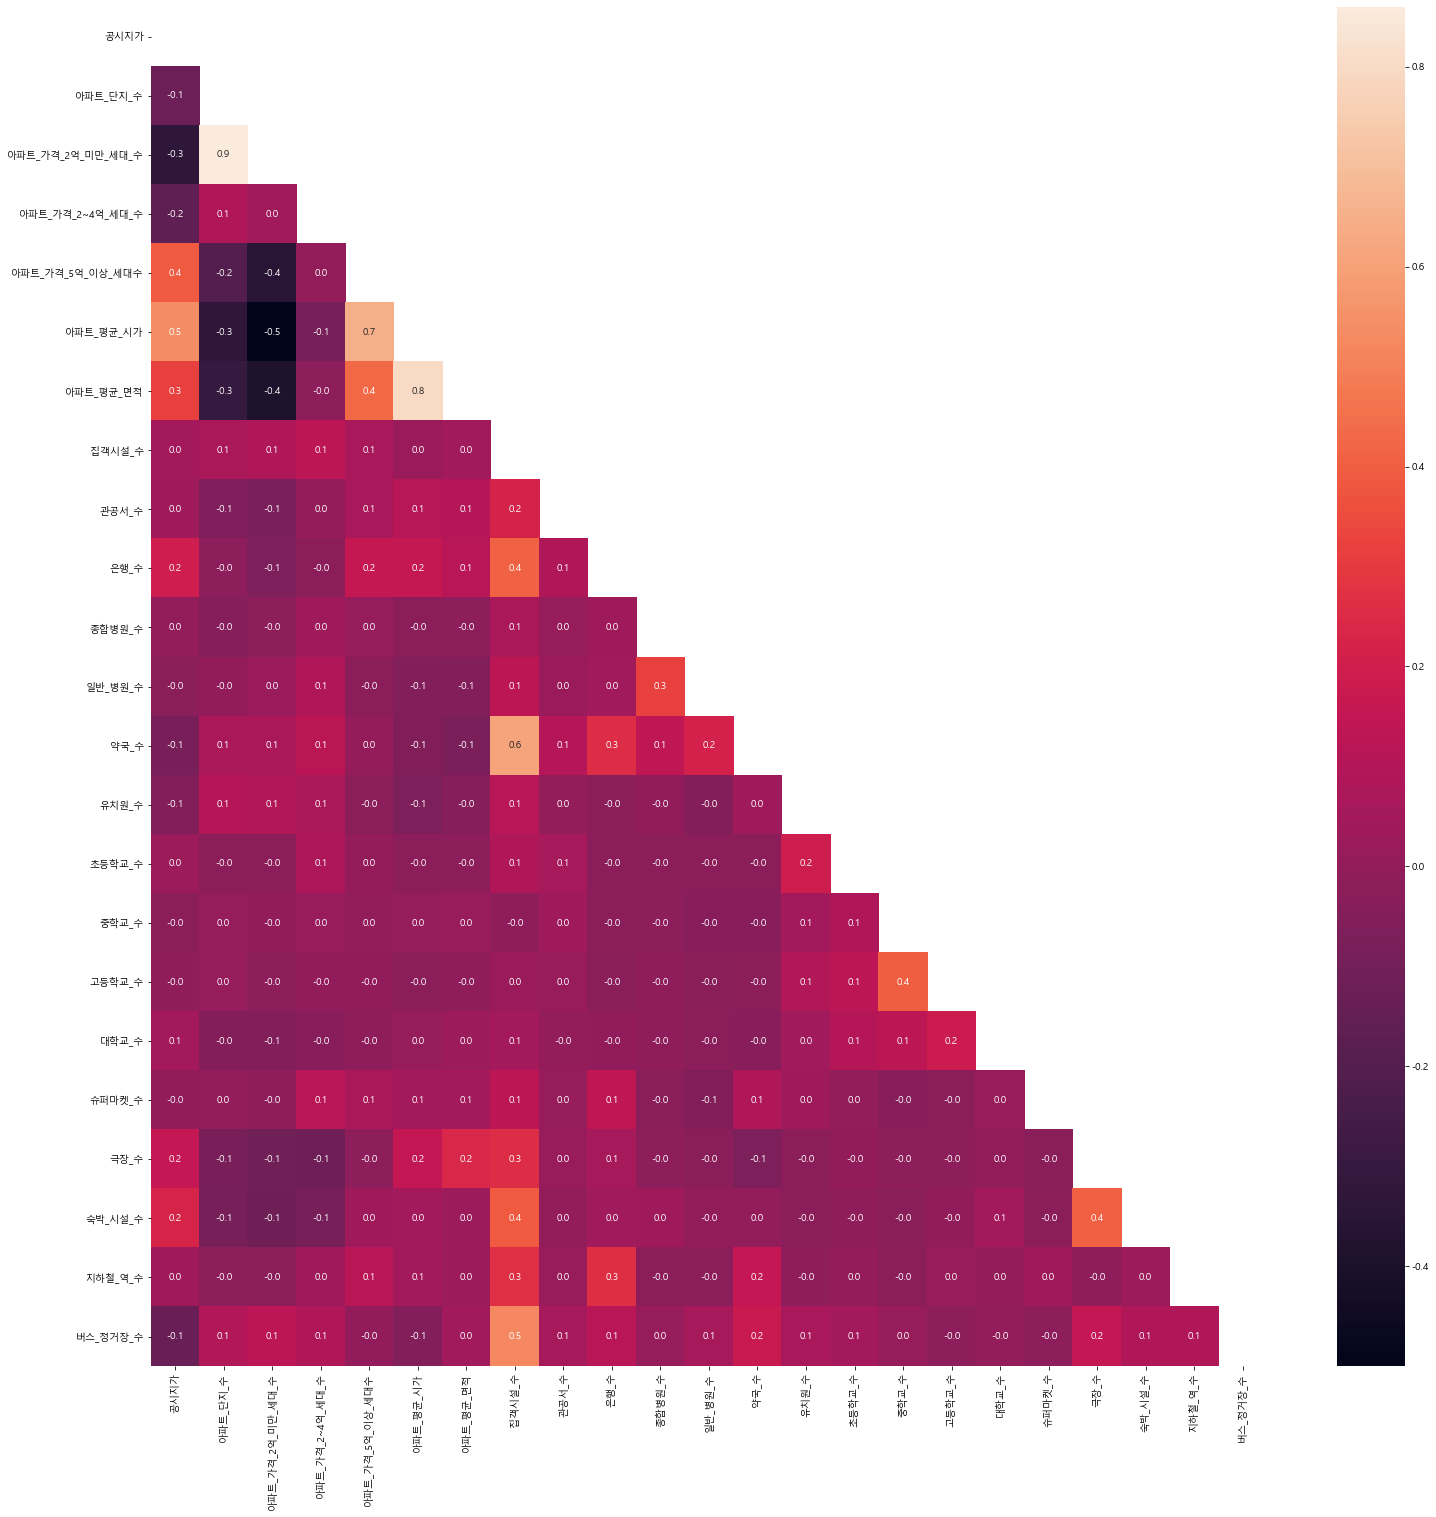

In [11]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(df_X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_X.corr(), mask=mask, fmt='.1f', annot=True);

In [12]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 면적당_매출   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.682
Method:                 Least Squares   F-statistic:                              95.22
Date:                Mon, 27 Dec 2021   Prob (F-statistic):                   1.29e-231
Time:                        22:00:08   Log-Likelihood:                         -5505.4
No. Observations:                1009   AIC:                                  1.106e+04
Df Residuals:                     986   BIC:                                  1.117e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
공시지가               9.439e-07   9.55e-07      0.989      0.323    -9.3e-07    2.82e-06
아파트_단지_수             -0.0111      0.006     -1.924      0.055      -0.022       0.000
아파트_가격_2억_미만_세대_수     0.0009      0.001      1.265      0.206      -0.001       0.002
아파트_가격_2~4억_세대_수     -0.0001      0.000     -0.225      0.822      -0.001       0.001
아파트_가격_5억_이상_세대수     -0.0020      0.001     -2.939      0.003      -0.003      -0.001
아파트_평균_시가          5.993e-08   2.62e-08      2.283      0.023    8.43e-09    1.11e-07
아파트_평균_면적             0.4631      0.145      3.183      0.002       0.178       0.749
집객시설_수                0.6748      0.137      4.922      0.000       0.406       0.944
관공서_수                -1.2817      0.687     -1.865      0.063      -2.630       0.067
은행_수                  2.7613      0.906      3.047      0.002       0.983       4.540
종합병원_수                0.7719      3.790      0.204      0.839      -6.666       8.210
일반_병원_수              -3.2594      1.756     -1.856      0.064      -6.705       0.186
약국_수                  2.8614      0.516      5.544      0.000       1.849       3.874
유치원_수                -2.2782      1.289     -1.768      0.077      -4.808       0.251
초등학교_수               -5.3708      2.564     -2.095      0.036     -10.403      -0.339
중학교_수                -7.6950      4.511     -1.706      0.088     -16.548       1.158
고등학교_수               -1.6028      4.590     -0.349      0.727     -10.611       7.405
대학교_수                 1.2238      1.341      0.913      0.362      -1.408       3.855
슈퍼마켓_수                1.3423      2.078      0.646      0.518      -2.736       5.420
극장_수                 -5.6782      1.074     -5.285      0.000      -7.787      -3.570
숙박_시설_수               1.2423      0.281      4.419      0.000       0.691       1.794
지하철_역_수               0.8380      2.812      0.298      0.766      -4.679       6.355
버스_정거장_수             -0.8594      0.298     -2.886      0.004      -1.444      -0.275
==============================================================================
Omnibus:                      701.116   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17451.754
Skew:                           2.831   Prob(JB):                         0.00
Kurtosis:                      22.572   Cond. No.                     8.19e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.19e+08. This might indicate that there are

In [13]:
path = '../data/indicator/fs_geo.csv'
df_X.to_csv(path)
pd.read_csv(path).head()

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,아파트_평균_면적,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수
0,1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,255243240.7500,68.0000,230.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,48.0000,114.0000,0.0000,34.0000
1,1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,229979099.5866,49.7500,29.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,9.0000,0.0000,4.0000
2,1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,177736607.7500,50.0000,152.0000,1.0000,3.0000,0.0000,0.0000,0.0000,4.0000,8.0000,0.0000,0.0000,1.0000,0.0000,3.0000,27.0000,0.0000,16.0000
3,1000004,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,148500313.0153,58.0000,44.0000,0.0000,0.0000,0.0000,0.0000,11.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,3.0000,0.0000,20.0000
4,1000005,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,337631733.3064,102.0000,27.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,3.0000,0.0000,12.0000


# 정규화

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df_X.columns
for col in cols:
    df_X[col] = scaler.fit_transform(np.array(df_X[col]).reshape(-1, 1))
    
df_X.describe()

,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,아파트_평균_면적,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수
count,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000
mean,0.1423,0.2073,0.1666,0.2087,0.0869,0.1579,0.3663,0.2014,0.0957,0.0609,0.0081,0.0401,0.1504,0.0823,0.0172,0.0134,0.0052,0.0047,0.0365,0.0051,0.0354,0.0278,0.1688
std,0.1253,0.1543,0.1411,0.1515,0.1346,0.0972,0.0818,0.1263,0.1543,0.1240,0.0722,0.1392,0.1550,0.1829,0.0922,0.1100,0.0549,0.0465,0.1290,0.0408,0.0745,0.1378,0.1613
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0725,0.0923,0.0673,0.0982,0.0000,0.1016,0.3228,0.1130,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0612
50%,0.1033,0.1674,0.1240,0.1746,0.0179,0.1260,0.3465,0.1783,0.0000,0.0000,0.0000,0.0000,0.1176,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1429
75%,0.1541,0.2734,0.2289,0.2826,0.1202,0.1791,0.3845,0.2609,0.2222,0.0526,0.0000,0.0000,0.2353,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0526,0.0000,0.2449
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


# 점수 지수화

In [15]:
i2_df = pd.DataFrame(columns=['i2_ind1'], index=df_X.index)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

lr = LinearRegression()
model = lr.fit(df_X, df_y)
coef = model.coef_.reshape(-1)

scaler = MinMaxScaler()
coef_df = np.array((df_X * coef).sum(axis=1))
i2_indi = scaler.fit_transform(coef_df.reshape(-1, 1))
# i2_indi = coef_df.reshape(-1, 1)
i2_df['i2_ind1'] = i2_indi.reshape(-1)

i2_df.head()

,i2_ind1
상권_코드,
1000001,0.3682
1000002,0.3415
1000003,0.4184
1000004,0.3392
1000005,0.1512


In [16]:
i2_df.to_csv('../data/indicator/indicator_i2.csv')
pd.read_csv('../data/indicator/indicator_i2.csv').head()

,상권_코드,i2_ind1
0,1000001,0.3682
1,1000002,0.3415
2,1000003,0.4184
3,1000004,0.3392
4,1000005,0.1512


In [17]:
i2_df['i2_ind1'].sum(axis=0)

334.99457969907985